# Outlier Analysis

**Purpose:** Identify extreme/unusual values and decide if they're real or errors

**Tasks:**
- Detect statistical outliers (Z-score, IQR)
- Investigate medical plausibility
- Decide: Keep (real medical case) or Remove (data error)

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import sys
!{sys.executable} -m pip install scipy
from scipy import stats

sns.set_style('whitegrid')

## Load Dataset

In [2]:
# Connect to database and load full dataset
conn = sqlite3.connect('../databases/nhanes_1st.db')
df = pd.read_sql_query('SELECT * FROM raw_dataset', conn)
conn.close()

print(f"Dataset shape: {df.shape}")
print(f"\nData types:")
print(df.dtypes.value_counts())

Dataset shape: (34097, 29)

Data types:
float64    28
int64       1
Name: count, dtype: int64


In [3]:
# Identify continuous numerical variables (exclude categorical targets and IDs)
continuous_cols = [
    'age', 'income_ratio', 'body_mass_index', 'height_cm', 'heart_rate_bpm',
    'white_blood_cells_count', 'platelets_count', 'hemoglobin_g_dl', 'mean_corpuscular_volume_fL',
    'creatinine_mg_dl', 'liver_ast_U_L', 'bilirubin_mg_dl', 'liver_ggt_U_L', 'uric_acid_mg_dl',
    'sodium_mmol_L', 'potassium_mmol_L', 'cholesterol_mg_dl', 'alcohol_drinks_per_week',
    'kidney_acr_mg_g', 'liver_alt_U_L'
]

# Filter to only existing columns with sufficient data
continuous_cols = [col for col in continuous_cols if col in df.columns and df[col].notna().sum() > 100]

print(f"Analyzing {len(continuous_cols)} continuous variables:")
for col in continuous_cols:
    print(f"  - {col}")

Analyzing 18 continuous variables:
  - age
  - income_ratio
  - body_mass_index
  - height_cm
  - heart_rate_bpm
  - white_blood_cells_count
  - platelets_count
  - hemoglobin_g_dl
  - mean_corpuscular_volume_fL
  - creatinine_mg_dl
  - liver_ast_U_L
  - bilirubin_mg_dl
  - liver_ggt_U_L
  - uric_acid_mg_dl
  - sodium_mmol_L
  - potassium_mmol_L
  - cholesterol_mg_dl
  - alcohol_drinks_per_week


In [4]:
# Calculate Z-scores for continuous variables
z_scores = pd.DataFrame()
outliers_zscore = {}

for col in continuous_cols:
    # Calculate Z-score for non-null values
    valid_data = df[col].dropna()
    if len(valid_data) > 0:
        z = np.abs(stats.zscore(valid_data))
        outliers_zscore[col] = (z > 3).sum()

# Create summary DataFrame
zscore_summary = pd.DataFrame.from_dict(outliers_zscore, orient='index', columns=['Outliers (Z > 3)'])
zscore_summary['Total Non-Null'] = [df[col].notna().sum() for col in zscore_summary.index]
zscore_summary['Outlier %'] = (zscore_summary['Outliers (Z > 3)'] / zscore_summary['Total Non-Null'] * 100).round(2)
zscore_summary = zscore_summary.sort_values('Outliers (Z > 3)', ascending=False)

print("Z-Score Method (|Z| > 3 indicates outlier):\n")
print(zscore_summary.to_string())
print(f"\n✓ Total outliers detected: {zscore_summary['Outliers (Z > 3)'].sum():,}")

Z-Score Method (|Z| > 3 indicates outlier):

                            Outliers (Z > 3)  Total Non-Null  Outlier %
alcohol_drinks_per_week                  519           23588       2.20
mean_corpuscular_volume_fL               504           29498       1.71
body_mass_index                          398           30452       1.31
liver_ggt_U_L                            365           28715       1.27
liver_ast_U_L                            358           28652       1.25
bilirubin_mg_dl                          358           28693       1.25
platelets_count                          287           29492       0.97
sodium_mmol_L                            286           28756       0.99
hemoglobin_g_dl                          269           29498       0.91
white_blood_cells_count                  262           29492       0.89
potassium_mmol_L                         210           28673       0.73
uric_acid_mg_dl                          189           28713       0.66
cholesterol_mg_dl  

In [5]:
# TODO: Calculate Z-scores for continuous variables
# z_scores = np.abs(stats.zscore(df[continuous_cols], nan_policy='omit'))
# outliers_zscore = (z_scores > 3).sum(axis=0)

In [6]:
# Detect outliers using IQR method
outliers_iqr = {}

for col in continuous_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define outlier boundaries
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Count outliers
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    outliers_iqr[col] = {
        'count': len(outliers),
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    }

# Create summary DataFrame
iqr_summary = pd.DataFrame({
    col: {
        'Outliers (IQR)': data['count'],
        'Lower Bound': round(data['lower_bound'], 2),
        'Upper Bound': round(data['upper_bound'], 2)
    } for col, data in outliers_iqr.items()
}).T

iqr_summary['Total Non-Null'] = [df[col].notna().sum() for col in iqr_summary.index]
iqr_summary['Outlier %'] = (iqr_summary['Outliers (IQR)'] / iqr_summary['Total Non-Null'] * 100).round(2)
iqr_summary = iqr_summary.sort_values('Outliers (IQR)', ascending=False)

print("IQR Method (values outside Q1 - 1.5×IQR to Q3 + 1.5×IQR):\n")
print(iqr_summary.to_string())
print(f"\n✓ Total outliers detected: {int(iqr_summary['Outliers (IQR)'].sum()):,}")

IQR Method (values outside Q1 - 1.5×IQR to Q3 + 1.5×IQR):

                            Outliers (IQR)  Lower Bound  Upper Bound  Total Non-Null  Outlier %
alcohol_drinks_per_week             2801.0        -5.25         8.75           23588      11.87
liver_ggt_U_L                       2531.0       -11.50        56.50           28715       8.81
liver_ast_U_L                       1483.0         3.50        39.50           28652       5.18
bilirubin_mg_dl                     1412.0        -0.15         1.05           28693       4.92
mean_corpuscular_volume_fL          1201.0        75.90       102.30           29498       4.07
creatinine_mg_dl                     963.0         0.27         1.44           28717       3.35
body_mass_index                      906.0        11.40        46.60           30452       2.98
sodium_mmol_L                        739.0       133.50       145.50           28756       2.57
white_blood_cells_count              655.0         1.65        12.45         

In [7]:
# Compare both methods
comparison = pd.DataFrame({
    'Z-Score Outliers': zscore_summary['Outliers (Z > 3)'],
    'IQR Outliers': iqr_summary['Outliers (IQR)'],
    'Z-Score %': zscore_summary['Outlier %'],
    'IQR %': iqr_summary['Outlier %']
})

print("Comparison of Outlier Detection Methods:\n")
print(comparison.to_string())
print("\nNote: IQR method typically detects more outliers as it's more sensitive to distribution shape")

Comparison of Outlier Detection Methods:

                            Z-Score Outliers  IQR Outliers  Z-Score %  IQR %
age                                        0           0.0       0.00   0.00
alcohol_drinks_per_week                  519        2801.0       2.20  11.87
bilirubin_mg_dl                          358        1412.0       1.25   4.92
body_mass_index                          398         906.0       1.31   2.98
cholesterol_mg_dl                        189         370.0       0.65   1.28
creatinine_mg_dl                         184         963.0       0.64   3.35
heart_rate_bpm                           179         427.0       0.65   1.55
height_cm                                 24          31.0       0.08   0.10
hemoglobin_g_dl                          269         461.0       0.91   1.56
income_ratio                               0           0.0       0.00   0.00
liver_ast_U_L                            358        1483.0       1.25   5.18
liver_ggt_U_L                     

In [8]:
# Define medical thresholds and check plausibility of outliers
medical_ranges = {
    'age': (0, 120, 'Keep', 'Age values are reasonable'),
    'body_mass_index': (10, 100, 'Keep', 'Extreme BMI values are rare but medically possible (severe malnutrition or obesity)'),
    'height_cm': (50, 250, 'Keep', 'Height outliers likely valid (children, very tall individuals)'),
    'heart_rate_bpm': (30, 200, 'Keep', 'Bradycardia (<40) and tachycardia (>100) are medically valid'),
    'white_blood_cells_count': (0.5, 50, 'Review', 'Very high values (>30) could be leukemia or infection; very low (<2) immunodeficiency'),
    'platelets_count': (20, 1000, 'Review', 'Values >500 or <50 are clinically significant, verify data quality'),
    'hemoglobin_g_dl': (5, 20, 'Keep', 'Low (<8) indicates anemia; high (>18) polycythemia - both medically valid'),
    'mean_corpuscular_volume_fL': (50, 120, 'Keep', 'MCV outliers indicate different anemia types (microcytic/macrocytic)'),
    'creatinine_mg_dl': (0.3, 15, 'Keep', 'High values indicate kidney disease - medically valid'),
    'liver_ast_U_L': (5, 1000, 'Keep', 'Very high AST can occur in acute liver injury'),
    'bilirubin_mg_dl': (0.1, 25, 'Keep', 'High bilirubin indicates liver/bile issues - valid'),
    'liver_ggt_U_L': (5, 1000, 'Keep', 'GGT can be very high in liver disease and alcohol abuse'),
    'uric_acid_mg_dl': (1, 15, 'Keep', 'High uric acid (gout) is medically valid'),
    'sodium_mmol_L': (120, 160, 'Review', 'Values outside 125-155 are life-threatening - verify data quality'),
    'potassium_mmol_L': (2.0, 7.0, 'Review', 'Values <2.5 or >6.0 are dangerous - verify data quality'),
    'cholesterol_mg_dl': (50, 500, 'Keep', 'Very high cholesterol is valid (familial hypercholesterolemia)'),
    'alcohol_drinks_per_week': (0, 150, 'Review', 'Very high values (>70) possible but verify data quality'),
    'income_ratio': (0, 5, 'Keep', 'All values within valid range'),
    'kidney_acr_mg_g': (0, 10, 'Keep', 'Log-transformed values; high ACR indicates kidney disease'),
    'liver_alt_U_L': (0, 7, 'Keep', 'Log-transformed values; high ALT indicates liver damage'),
}

# Create medical plausibility assessment table
plausibility_data = []
for col in continuous_cols:
    if col in medical_ranges:
        min_val, max_val, decision, reason = medical_ranges[col]
        
        # Get actual data range
        actual_min = df[col].min()
        actual_max = df[col].max()
        
        # Count values outside medical range
        outside_range = df[(df[col] < min_val) | (df[col] > max_val)][col].notna().sum()
        
        plausibility_data.append({
            'Variable': col,
            'Medical Range': f'[{min_val}, {max_val}]',
            'Actual Range': f'[{actual_min:.2f}, {actual_max:.2f}]',
            'Outside Range': outside_range,
            'Decision': decision,
            'Rationale': reason
        })

plausibility_df = pd.DataFrame(plausibility_data)

print("Medical Plausibility Assessment:\n")
print("="*120)
for _, row in plausibility_df.iterrows():
    print(f"\n{row['Variable']}:")
    print(f"  Medical Range: {row['Medical Range']}")
    print(f"  Actual Range: {row['Actual Range']}")
    print(f"  Values Outside Medical Range: {row['Outside Range']}")
    print(f"  Decision: {row['Decision']}")
    print(f"  Rationale: {row['Rationale']}")

Medical Plausibility Assessment:


age:
  Medical Range: [0, 120]
  Actual Range: [20.00, 80.00]
  Values Outside Medical Range: 0
  Decision: Keep
  Rationale: Age values are reasonable

income_ratio:
  Medical Range: [0, 5]
  Actual Range: [0.00, 5.00]
  Values Outside Medical Range: 0
  Decision: Keep
  Rationale: All values within valid range

body_mass_index:
  Medical Range: [10, 100]
  Actual Range: [11.10, 92.30]
  Values Outside Medical Range: 0
  Decision: Keep
  Rationale: Extreme BMI values are rare but medically possible (severe malnutrition or obesity)

height_cm:
  Medical Range: [50, 250]
  Actual Range: [129.70, 202.70]
  Values Outside Medical Range: 0
  Decision: Keep
  Rationale: Height outliers likely valid (children, very tall individuals)

heart_rate_bpm:
  Medical Range: [30, 200]
  Actual Range: [34.00, 160.00]
  Values Outside Medical Range: 0
  Decision: Keep
  Rationale: Bradycardia (<40) and tachycardia (>100) are medically valid

white_blood_cells_count:
 

In [9]:
# TODO: Detect outliers using IQR method
# Q1 = df.quantile(0.25)
# Q3 = df.quantile(0.75)
# IQR = Q3 - Q1
# outliers_iqr = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum()

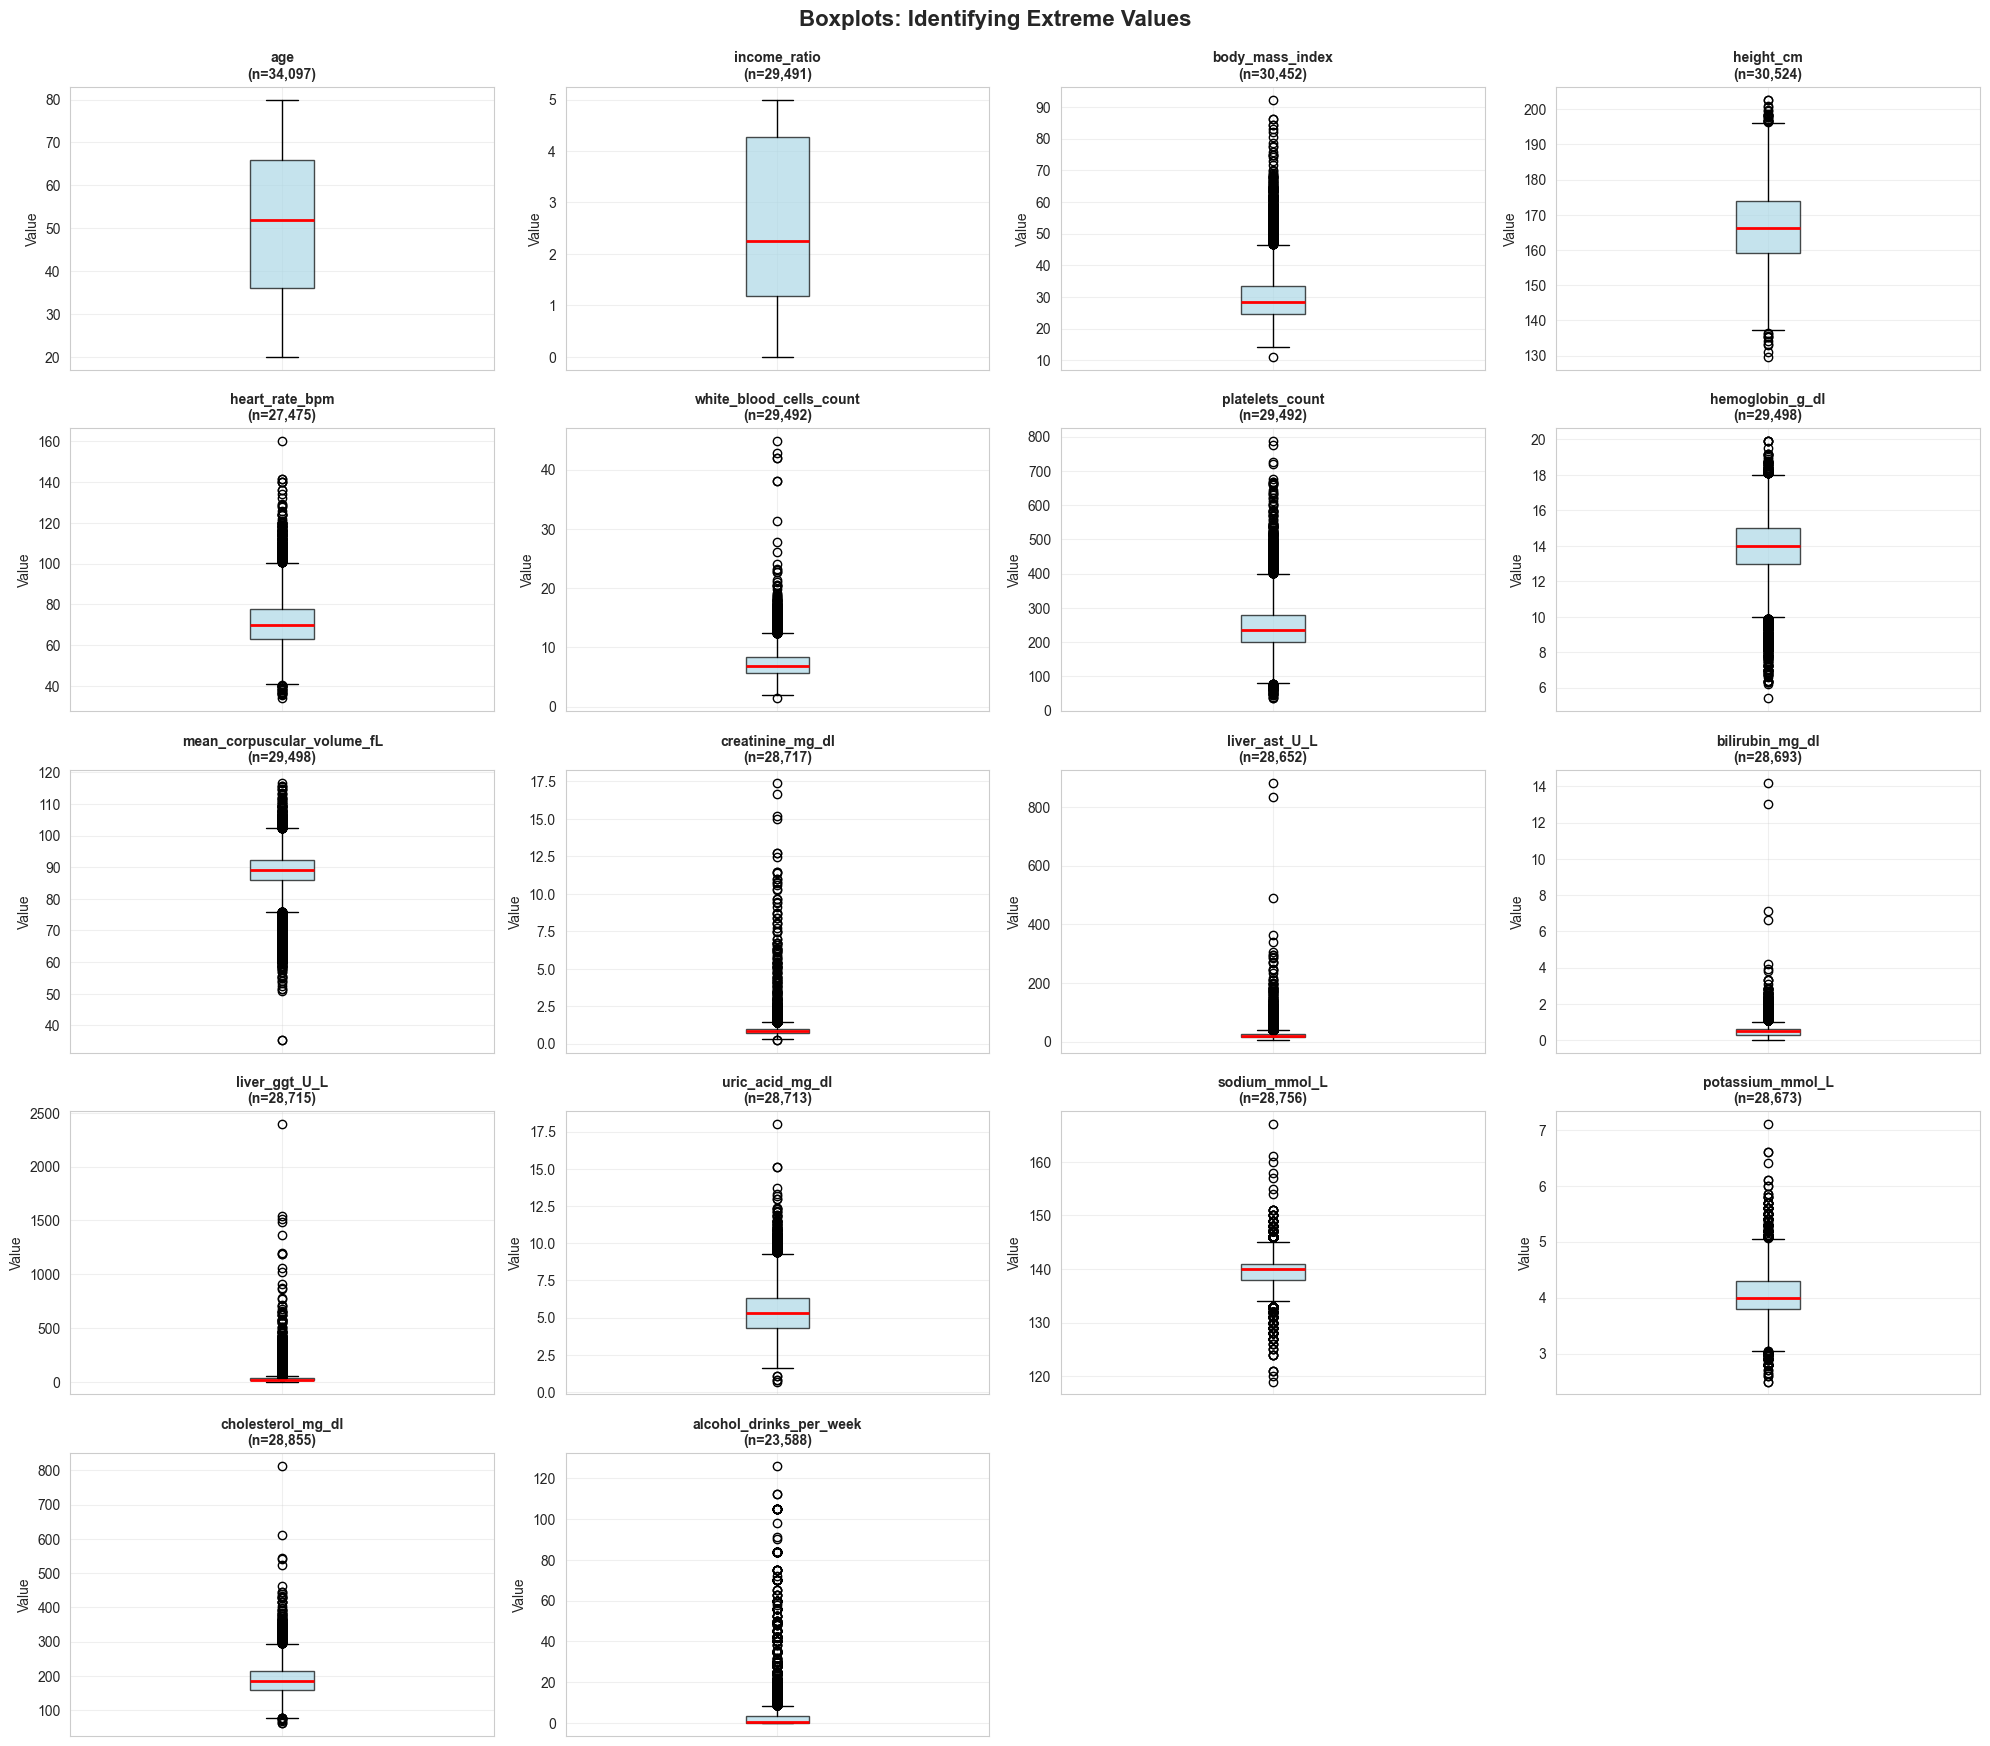

✓ Boxplots show median (red line), quartiles (box), and outliers (points beyond whiskers)


In [10]:
# Create boxplots for each continuous variable to visualize extreme values
n_cols = 4
n_rows = int(np.ceil(len(continuous_cols) / n_cols))

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, n_rows * 3.5))
axes = axes.flatten()

for idx, col in enumerate(continuous_cols):
    ax = axes[idx]
    
    # Create boxplot
    data_to_plot = df[col].dropna()
    bp = ax.boxplot([data_to_plot], vert=True, patch_artist=True)
    
    # Styling
    bp['boxes'][0].set_facecolor('lightblue')
    bp['boxes'][0].set_alpha(0.7)
    bp['medians'][0].set_color('red')
    bp['medians'][0].set_linewidth(2)
    
    # Add title and labels
    ax.set_title(f'{col}\n(n={len(data_to_plot):,})', fontsize=10, fontweight='bold')
    ax.set_ylabel('Value')
    ax.grid(True, alpha=0.3)
    ax.set_xticklabels([''])

# Remove empty subplots
for idx in range(len(continuous_cols), len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle('Boxplots: Identifying Extreme Values', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("✓ Boxplots show median (red line), quartiles (box), and outliers (points beyond whiskers)")

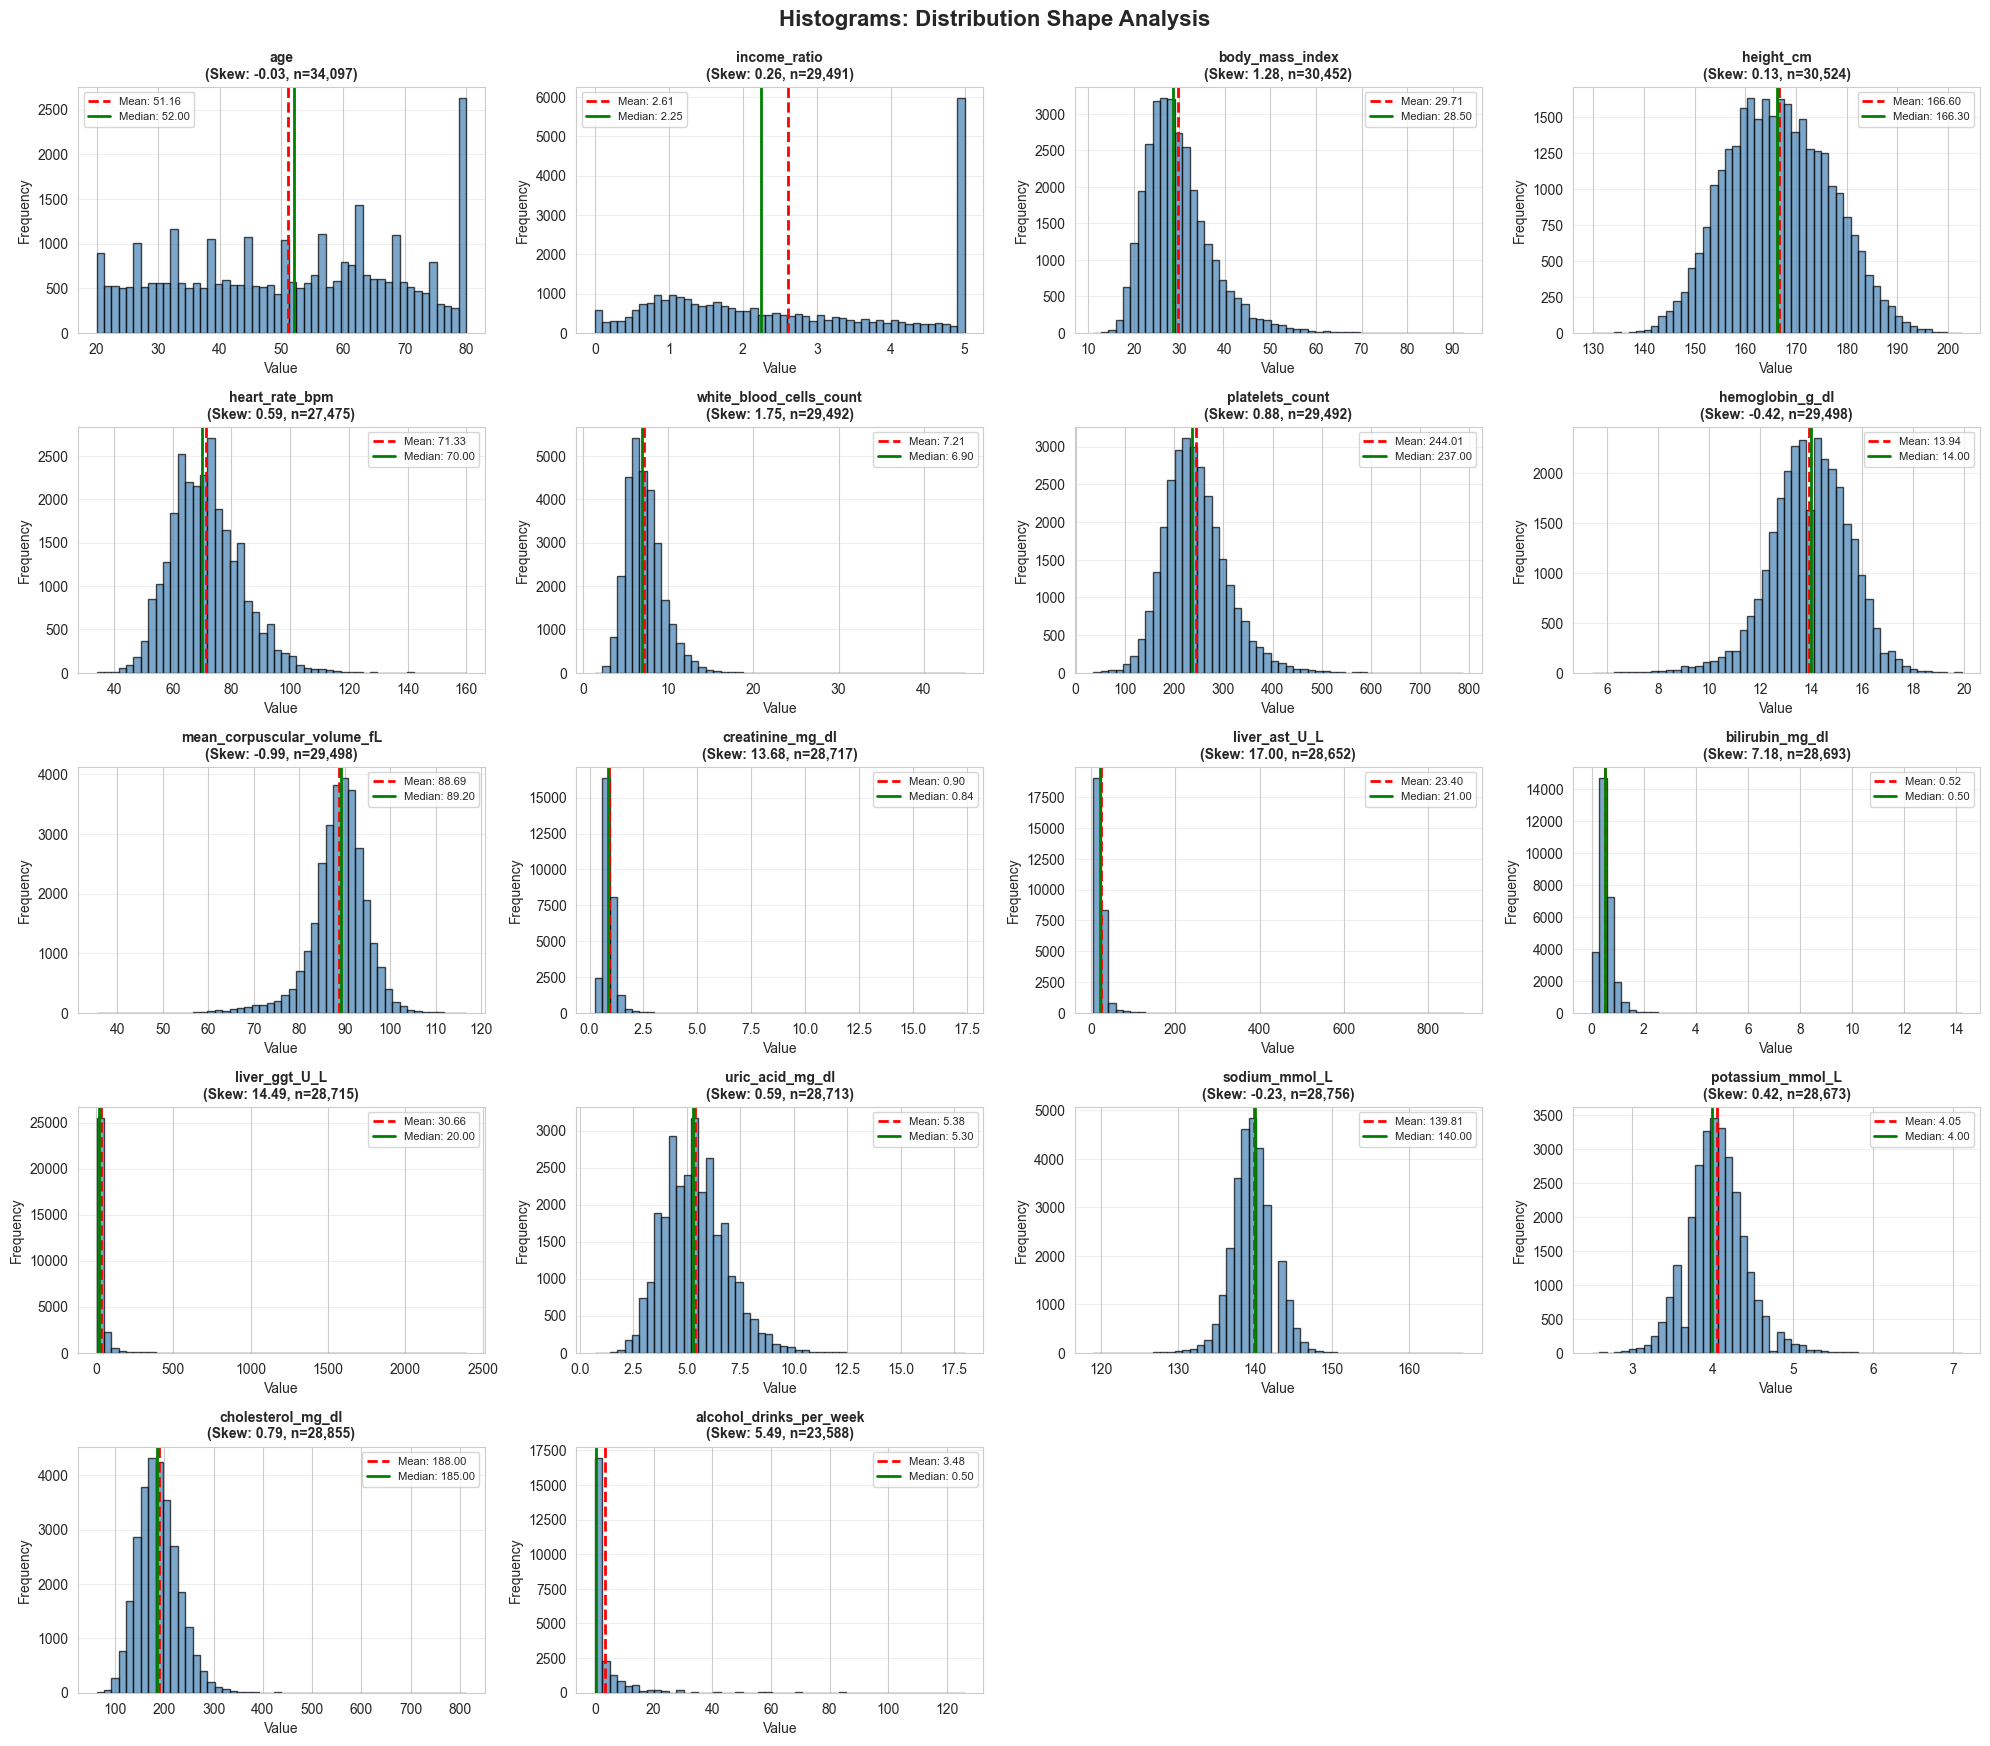

✓ Histograms show distribution shape and skewness
  - Skewness near 0: Symmetric distribution
  - Positive skew: Long tail on the right
  - Negative skew: Long tail on the left


In [11]:
# Create histograms to check for weird distributions
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, n_rows * 3.5))
axes = axes.flatten()

for idx, col in enumerate(continuous_cols):
    ax = axes[idx]
    
    # Create histogram
    data_to_plot = df[col].dropna()
    ax.hist(data_to_plot, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
    
    # Add mean and median lines
    mean_val = data_to_plot.mean()
    median_val = data_to_plot.median()
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    ax.axvline(median_val, color='green', linestyle='-', linewidth=2, label=f'Median: {median_val:.2f}')
    
    # Calculate skewness
    skewness = data_to_plot.skew()
    
    # Add title and labels
    ax.set_title(f'{col}\n(Skew: {skewness:.2f}, n={len(data_to_plot):,})', fontsize=10, fontweight='bold')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3, axis='y')

# Remove empty subplots
for idx in range(len(continuous_cols), len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle('Histograms: Distribution Shape Analysis', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("✓ Histograms show distribution shape and skewness")
print("  - Skewness near 0: Symmetric distribution")
print("  - Positive skew: Long tail on the right")
print("  - Negative skew: Long tail on the left")

In [12]:
# Create decision log for outlier handling
decision_log = plausibility_df[['Variable', 'Decision', 'Rationale']].copy()

print("="*120)
print("OUTLIER HANDLING DECISION LOG")
print("="*120)
print("\nVARIABLES TO KEEP (Outliers are medically valid):")
keep_vars = decision_log[decision_log['Decision'] == 'Keep']
for _, row in keep_vars.iterrows():
    print(f"  ✓ {row['Variable']}: {row['Rationale']}")

print("\n\nVARIABLES TO REVIEW (Verify data quality):")
review_vars = decision_log[decision_log['Decision'] == 'Review']
for _, row in review_vars.iterrows():
    print(f"  ⚠ {row['Variable']}: {row['Rationale']}")

print(f"\n\n{'='*120}")
print(f"Summary: {len(keep_vars)} variables with valid outliers, {len(review_vars)} variables needing review")
print("="*120)

OUTLIER HANDLING DECISION LOG

VARIABLES TO KEEP (Outliers are medically valid):
  ✓ age: Age values are reasonable
  ✓ income_ratio: All values within valid range
  ✓ body_mass_index: Extreme BMI values are rare but medically possible (severe malnutrition or obesity)
  ✓ height_cm: Height outliers likely valid (children, very tall individuals)
  ✓ heart_rate_bpm: Bradycardia (<40) and tachycardia (>100) are medically valid
  ✓ hemoglobin_g_dl: Low (<8) indicates anemia; high (>18) polycythemia - both medically valid
  ✓ mean_corpuscular_volume_fL: MCV outliers indicate different anemia types (microcytic/macrocytic)
  ✓ creatinine_mg_dl: High values indicate kidney disease - medically valid
  ✓ liver_ast_U_L: Very high AST can occur in acute liver injury
  ✓ bilirubin_mg_dl: High bilirubin indicates liver/bile issues - valid
  ✓ liver_ggt_U_L: GGT can be very high in liver disease and alcohol abuse
  ✓ uric_acid_mg_dl: High uric acid (gout) is medically valid
  ✓ cholesterol_mg_dl: Ver

In [13]:
# TODO: Define medical thresholds for each variable
# Check outliers against clinical knowledge

In [14]:
print("="*120)
print("OUTLIER ANALYSIS SUMMARY")
print("="*120)

print(f"\n📊 DATASET OVERVIEW:")
print(f"  • Total records: {len(df):,}")
print(f"  • Continuous variables analyzed: {len(continuous_cols)}")

print(f"\n🔍 OUTLIER DETECTION RESULTS:")
print(f"  • Z-Score method (|Z| > 3): {zscore_summary['Outliers (Z > 3)'].sum():,.0f} outliers detected")
print(f"  • IQR method: {iqr_summary['Outliers (IQR)'].sum():,.0f} outliers detected")
print(f"  • Note: IQR is more sensitive and detects more outliers")

print(f"\n📈 TOP 5 VARIABLES WITH MOST OUTLIERS (IQR method):")
top_5_outliers = iqr_summary.nlargest(5, 'Outliers (IQR)')[['Outliers (IQR)', 'Outlier %']]
for var, row in top_5_outliers.iterrows():
    print(f"  • {var}: {row['Outliers (IQR)']:.0f} outliers ({row['Outlier %']:.2f}%)")

print(f"\n📋 DISTRIBUTION CHARACTERISTICS:")
highly_skewed = []
for col in continuous_cols:
    skew = df[col].dropna().skew()
    if abs(skew) > 2:
        highly_skewed.append((col, skew))

if highly_skewed:
    print(f"  • Variables with high skewness (|skew| > 2):")
    for var, skew in sorted(highly_skewed, key=lambda x: abs(x[1]), reverse=True):
        direction = "right-skewed" if skew > 0 else "left-skewed"
        print(f"    - {var}: {skew:.2f} ({direction})")
else:
    print(f"  • No highly skewed variables detected")

print(f"\n✅ RECOMMENDATIONS:")
print(f"  1. KEEP outliers for variables marked as 'Keep' - they represent valid medical conditions")
print(f"  2. REVIEW outliers for {len(review_vars)} variables marked for review:")
for _, row in review_vars.iterrows():
    print(f"     - {row['Variable']}")
print(f"  3. Consider log transformation for highly skewed variables in modeling")
print(f"  4. Use robust scaling methods (e.g., RobustScaler) that are less sensitive to outliers")
print(f"  5. For tree-based models, outliers are generally not problematic")

print(f"\n💡 NEXT STEPS:")
print(f"  • Proceed with data cleaning based on the decision log")
print(f"  • Document any values removed as data errors")
print(f"  • Keep outliers that represent real medical cases for training")
print(f"  • Consider outlier-robust modeling techniques")

print("\n" + "="*120)

OUTLIER ANALYSIS SUMMARY

📊 DATASET OVERVIEW:
  • Total records: 34,097
  • Continuous variables analyzed: 18

🔍 OUTLIER DETECTION RESULTS:
  • Z-Score method (|Z| > 3): 4,581 outliers detected
  • IQR method: 15,291 outliers detected
  • Note: IQR is more sensitive and detects more outliers

📈 TOP 5 VARIABLES WITH MOST OUTLIERS (IQR method):
  • alcohol_drinks_per_week: 2801 outliers (11.87%)
  • liver_ggt_U_L: 2531 outliers (8.81%)
  • liver_ast_U_L: 1483 outliers (5.18%)
  • bilirubin_mg_dl: 1412 outliers (4.92%)
  • mean_corpuscular_volume_fL: 1201 outliers (4.07%)

📋 DISTRIBUTION CHARACTERISTICS:
  • Variables with high skewness (|skew| > 2):
    - liver_ast_U_L: 17.00 (right-skewed)
    - liver_ggt_U_L: 14.49 (right-skewed)
    - creatinine_mg_dl: 13.68 (right-skewed)
    - bilirubin_mg_dl: 7.18 (right-skewed)
    - alcohol_drinks_per_week: 5.49 (right-skewed)

✅ RECOMMENDATIONS:
  1. KEEP outliers for variables marked as 'Keep' - they represent valid medical conditions
  2. REVI

In [15]:
# TODO: Create boxplots for each continuous variable
# fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 15))
# for idx, col in enumerate(continuous_cols):
#     ax = axes.flatten()[idx]
#     df.boxplot(column=col, ax=ax)
# plt.tight_layout()

## 4. Decision: Keep or Remove?

In [16]:
# TODO: Document decisions for each outlier type
# Create a decision log table

## Summary

In [17]:
# TODO: Summarize outlier findings and decisions